In [21]:
import gurobipy as gb
from gurobipy import GRB
import math
import numpy as np
import matplotlib.pyplot as plt

In [22]:
gb.setParam("MIPGap", 1e-8)

Parameter MIPGap unchanged
   Value: 1e-08  Min: 0.0  Max: inf  Default: 0.0001


In [23]:
def calculate_optimal_gurobi(l0=None, l1=None, l2=None, B=None, lb=None, ub=None, M=100):
    m = gb.Model('box_constraint_test')
    m.setParam( 'OutputFlag', False )
    # Variables
    
    Bi = m.addVar(lb=lb, ub=ub, vtype=GRB.CONTINUOUS, name="Bi")
    Bi_supp = m.addVar(vtype=GRB.BINARY, name = '1[Bi]')
    Bi_sign = m.addVar(vtype=GRB.BINARY)
    Bi_pos = m.addVar(lb=0, ub=ub, vtype=GRB.CONTINUOUS)
    Bi_neg = m.addVar(lb=0, ub=-lb, vtype=GRB.CONTINUOUS)
    
    #Constraints
    m.addConstr(Bi_pos <= M*Bi_sign)
    m.addConstr(Bi_neg <= M*(1-Bi_sign))
    m.addConstr(Bi == Bi_pos - Bi_neg)

    m.addConstr(Bi >= -M*Bi_supp)
    m.addConstr(Bi <= M*Bi_supp)
    
    #Cost
    m.setObjective(0.5*(B - Bi)*(B - Bi) 
                   + l0*Bi_supp
                   + l1*(Bi_pos + Bi_neg) 
                   + l2*Bi*Bi, GRB.MINIMIZE)
    
    m.optimize()
    
    for v in m.getVars():
        if v.varName == "Bi":
            return v.x

In [24]:
def closed_form_niave(l0=None, l1=None, l2=None, B=None, lb=None, ub=None, M=None):
    Bi = B # Attempt to make Bi, B. This is solved for iteratively using other approaches
    
    two_l2_p1 = 1 + 2*l2
    
    x_opt_no_L0 = np.sign(Bi)*(np.abs(Bi) - l1)/two_l2_p1
    x = np.clip(x_opt_no_L0, lb, ub)
    
    
    if (np.abs(Bi) - l1)/two_l2_p1 < math.sqrt(2*l0/two_l2_p1):
        return 0
    
    delta = math.sqrt((abs(Bi) - l1)**2 - 2*l0*two_l2_p1)
    if x < x_opt_no_L0 - delta/two_l2_p1 or x > x_opt_no_L0 + delta/two_l2_p1:
        return 0
    else:
        return x


def closed_form_scalar(l0=None, l1=None, l2=None, B=None, lb=None, ub=None):
    Bi = B # Attempt to make Bi, B. This is solved for iteratively using other approaches
    two_l2_p1 = 1 + 2*l2
    two_l0 = 2*l0
    abs_Bi_m_l1 = np.abs(Bi) - l1
    ns_x_opt_no_L0 = abs_Bi_m_l1/two_l2_p1
    x_opt_no_L0 = np.sign(Bi)*ns_x_opt_no_L0
    x = np.clip(x_opt_no_L0, lb, ub)
    
    if ns_x_opt_no_L0 < np.sqrt(two_l0/two_l2_p1):
        return 0
    
    delta = np.sqrt(abs_Bi_m_l1**2 - two_l0*two_l2_p1)/two_l2_p1
    if x < x_opt_no_L0 - delta or x > x_opt_no_L0 + delta:
        return 0
    else:
        return x
    
    
def closed_form_vec(l0=None, l1=None, l2=None, B=None, lb=None, ub=None):
    Bi = B # Attempt to make Bi, B. This is solved for iteratively using other approaches
    two_l2_p1 = 1 + 2*l2
    two_l0 = 2*l0
    abs_Bi_m_l1 = np.abs(Bi) - l1
    ns_x_opt_no_L0 = abs_Bi_m_l1/two_l2_p1
    x_opt_no_L0 = np.sign(Bi)*ns_x_opt_no_L0
    x = np.clip(x_opt_no_L0, lb, ub)
    delta = np.sqrt(np.maximum(abs_Bi_m_l1**2 - two_l0*two_l2_p1, 0.))/two_l2_p1
    
    crit_1 = ns_x_opt_no_L0 >= np.sqrt(two_l0/two_l2_p1)
    crit_2 = x_opt_no_L0 - delta <= x <= x_opt_no_L0 + delta
    
    return x*(crit_1 | crit_1)
    

In [25]:
gb.setParam("MIPGap", 1e-8)

Parameter MIPGap unchanged
   Value: 1e-08  Min: 0.0  Max: inf  Default: 0.0001


In [26]:
def cost(B, Bi, l0, l1, l2):
    return 0.5*(B - Bi)**2 + l0*(Bi!=0) + l1*abs(Bi) + l2*Bi**2

In [27]:
B=-2.504072
l0=0.622172 
l1=0.877390
l2=0.189987
lb=-0.432078
ub=0.741855

In [28]:
Bi_optimal = calculate_optimal_gurobi(l0=l0, l1=l1, l2=l2, B=B , lb=lb, ub=ub, M = 1000)
print(Bi_optimal, cost(B, Bi_optimal, l0, l1, l2))

0.0 3.1351882905919997


In [29]:
Bi_box = closed_form_vec(l0=l0, l1=l1, l2=l2, B=B , lb=lb, ub=ub)
print(Bi_box, cost(B, Bi_box, l0, l1, l2))

-0.432078 3.1833214230857845


In [36]:
Bi_box = closed_form_niave(l0=l0, l1=l1, l2=l2, B=B , lb=lb, ub=ub)
print(Bi_box, cost(B, Bi_box, l0, l1, l2))

0 3.1351882905919997


In [30]:
cost(B, 0, l0, l1, l2)

3.1351882905919997

minimium v = 3.1833214230857845 at x = -0.432078


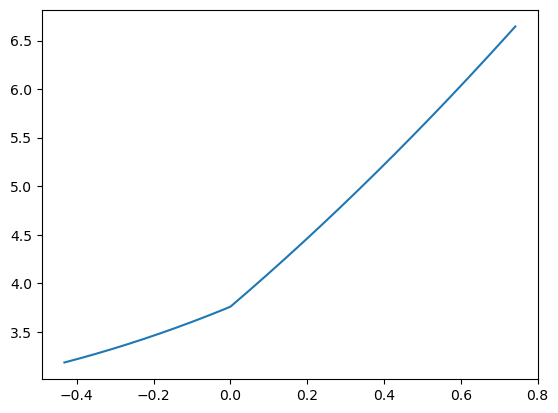

In [31]:
x = np.linspace(lb, ub, 1000000)

v = [cost(B, xi, l0, l1, l2) for xi in x]
#v = [abs(xi)*l1 for xi in x]
min_vi = np.argmin(v)
print(f"minimium v = {v[min_vi]} at x = {x[min_vi]}")
plt.plot(x, v)
plt.show()

In [32]:
import hypothesis
from hypothesis import given, settings, assume, example
from hypothesis.strategies import floats
import numpy as np

# Lets run on our problem

# Compare values

In [34]:
@given(l0=floats(0, 10), l1 = floats(0, 10), l2 = floats(0, 10),
       B=floats(-10, 10), lb=floats(-1, 0), ub=floats(0, 1))
@settings(max_examples=100000)
@example(l0=0, l1=0, l2=0, B=1, lb=-1, ub=1)
@example(l0=0, l1=0, l2=10, B=1, lb=-1, ub=1)
@example(l0=0, l1=10, l2=0, B=1, lb=-1, ub=1)
@example(l0=0, l1=10, l2=10, B=1, lb=-1, ub=1)
@example(l0=10, l1=0, l2=10, B=1, lb=-1, ub=1)
@example(l0=10, l1=10, l2=0, B=1, lb=-1, ub=1)
@example(l0=10, l1=10, l2=10, B=1, lb=-1, ub=1)
@example(l0=0.622172,  l1=0.877390, l2=0.189987, B=-2.504072, lb=-0.432078, ub=0.741855)
@example(l0=0, l1=0, l2 =0,B =-0.1, lb=-0.02, ub=0)
@example(l0=0.0061658496635019775, l1=0.0, l2=1e-4, B=4, lb=0.0, ub=0.0015000000000000573)
def compare_B(l0, l1, l2, B, lb, ub):
    try:
        gurobi_Bi = calculate_optimal_gurobi(l0=l0, l1=l1, l2=l2, B=B , lb=lb, ub=ub)
        closed_Bi = closed_form_vec(l0=l0, l1=l1, l2=l2, B=B , lb=lb, ub=ub)
        np.testing.assert_almost_equal(calculate_optimal_gurobi(l0=l0, l1=l1, l2=l2, B=B , lb=lb, ub=ub),
                                       closed_form_niave(l0=l0, l1=l1, l2=l2, B=B , lb=lb, ub=ub))
    except AssertionError:
        print(f"l0={l0}, l1={l1}, l2={l2}, B={B}, lb={lb}, ub={ub}, gurobi_Bi={gurobi_Bi}, closed_Bi={closed_Bi}")
        
        gurobi_cost = cost(B, gurobi_Bi, l0=l0, l1=l1, l2=l2)
        closed_cost = cost(B, closed_Bi, l0=l0, l1=l1, l2=l2)
        if cost(B, gurobi_Bi, l0=l0, l1=l1, l2=l2) < cost(B, closed_Bi, l0=l0, l1=l1, l2=l2):
            print(f"l0={l0}, l1={l1}, l2={l2}, B={B}, lb={lb}, ub={ub}, gurobi_cost={gurobi_cost}, closed_cost={closed_cost}")
            raise AssertionError

In [47]:
#

In [35]:
compare_B()

l0=7.981881265572732, l1=9.531601676879383, l2=2.61393622054416, B=-5.569986640927262, lb=-3.1254913057665595e-07, ub=0.6891326312114662, gurobi_Bi=-3.1254913057665595e-07, closed_Bi=0.0
l0=7.981881265572732, l1=9.531601676879383, l2=2.61393622054416, B=-3.1254913057665594e-06, lb=-3.1254913057665595e-07, ub=0.6891326312114662, gurobi_Bi=-3.1254913057665595e-07, closed_Bi=0.0
l0=7.981881265572732, l1=9.531601676879383, l2=2.61393622054416, B=-3.1254913057665594e-06, lb=-3.1254913057665595e-07, ub=0.261393622054416, gurobi_Bi=-3.1254913057665595e-07, closed_Bi=0.0
l0=7.981881265572732, l1=9.531601676879383, l2=2.61393622054416, B=-3.1254913057665594e-06, lb=-3.1254913057665595e-07, ub=0.7981881265572732, gurobi_Bi=-3.1254913057665595e-07, closed_Bi=0.0
l0=0.00010464175890012585, l1=0.00010464175890012585, l2=5.086655999238054, B=8.932875824477835, lb=0.0, ub=0.9087566062808057, gurobi_Bi=0.7994635821194833, closed_Bi=0.7994738877726897
You can add @seed(181939730396086777692416815959402

KeyboardInterrupt: 

In [ ]:
Bi_box = closed_form_niave(l0=0, l1=10, l2=0, B=1, lb=-1, ub=1)
print(Bi_box, cost(B, Bi_box, l0, l1, l2))

In [ ]:
Bi_optimal = calculate_optimal_gurobi(l0=0, l1=10, l2=0, B=1, lb=-1, ub=1)
print(Bi_optimal, cost(B, Bi_optimal, l0, l1, l2))

# Compare Objectives

In [ ]:
@given(l0=floats(0, 10), l1 = floats(0, 10), l2 = floats(0, 10),
       B=floats(0, 10), lb=floats(-1, 0), ub=floats(0, 1))
@settings(max_examples=1000, derandomize=True)
def compare_obj(l0, l1, l2, B, lb, ub):
    global decimal
    Bi_optimal = calculate_optimal_gurobi(l0=l0, l1=l1, l2=l2, B=B , lb=lb, ub=ub)
    Bi_box = closed_form_niave(l0=l0, l1=l1, l2=l2, B=B , lb=lb, ub=ub)
    
    try:
        np.testing.assert_almost_equal(cost(B, Bi_optimal, l0, l1, l2),
                                       cost(B, Bi_box, l0, l1, l2), decimal=decimal)
    except AssertionError as e:
        print(Bi_optimal, Bi_box)
        raise 

In [ ]:
decimal = 6
compare_obj()